In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from tools import depletion_func, calc_total_reward_rate, moving_window_avg, calculate_optimal_stops

In [2]:
# Example usage
type_patches = 2
num_patches = 400

#Three alternative ways to generate a list of patches
patch_list = list(range(type_patches)) #equal distribution of patches
# patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched
# patch_list = data # import data from session {To Be Implemented..}

# Initial probabilities of reward in each patch
travel_time = 3
reward_value = [5, 5]
a = [0.9, 0.4]
b = [2.76, 2.76]
c = [0.1278, 0.1278]
d = [0, 0]

mvt_optimal = calculate_optimal_stops(patch_list, travel_time, reward_value, a, b, c, d)

print(f"Optimal stops: {mvt_optimal['optimal_stops'][0]}, {mvt_optimal['optimal_stops'][1]}")
print(f"Max reward rate: {mvt_optimal['max_reward_rate']}")

Optimal stops: 8, 2
Max reward rate: 1.7275262225772854


In [3]:
class PatchForager:
    def __init__(self, travel_time, reward_value, a, b, c, d, prob=False):
        self.travel_time = travel_time
        self.reward_value = reward_value
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.prob = prob

    def depletion_func(self, patch_id, t):
        return self.a[patch_id] * (self.b[patch_id] ** (-self.c[patch_id]*t)+self.d[patch_id])

    def gen_bern(self, p):
        return 1 if random.random() < p else 0

In [8]:
def run_simulation(forager, strategy, patch_list, **strategy_params):
    data = []
    total_time = 0
    patch_entry_time = 0
    
    for patch_id in patch_list:
        t_in_patch = 0
        patch_reward = 0 #value
        rewards_in_patch = 0 #instances
        failures_in_patch = 0 #instances
        
        while True:
            prob_reward = forager.depletion_func(patch_id, t_in_patch)
            if forager.prob:
                reward = forager.gen_bern(prob_reward) * forager.reward_value[patch_id]
            else:
                reward = prob_reward * forager.reward_value[patch_id]
            
            patch_reward += reward
            total_time += 1
            t_in_patch += 1
            
            if reward > 0:
                rewards_in_patch += 1
            else:
                failures_in_patch += 1
            
            data.append({
                'time': total_time,
                'patch_id': patch_id,
                'time_in_patch': t_in_patch,
                'reward': reward,
                'cumulative_patch_reward': patch_reward,
                'prob_reward': prob_reward,
                'rewards_in_patch': rewards_in_patch,
                'failures_in_patch': failures_in_patch,
                'patch_entry_time': patch_entry_time
            })


            # print(strategy_params)
            
            # Check exit condition based on strategy
            if strategy == 'target_stops':
                if t_in_patch >= strategy_params['target_stops'][patch_id]:
                    break
            if strategy == 'mvt_rate':
                current_rate = patch_reward / (t_in_patch + forager.travel_time)
                # print(current_rate)
                if current_rate < strategy_params['target_reward_rate']:     
                    break
            elif strategy == 'fixed_rewards':
                if rewards_in_patch >= strategy_params['target_rewards']:
                    break
            elif strategy == 'fixed_failures':
                if failures_in_patch > strategy_params['max_failures']:
                    break
        
        # Add travel time
        total_time += forager.travel_time
        data.append({
            'time': total_time,
            'patch_id': -1,  # -1 indicates traveling
            'time_in_patch': forager.travel_time,
            'reward': 0,
            'cumulative_patch_reward': 0,
            'prob_reward': 0,
            'rewards_in_patch': 0,
            'failures_in_patch': 0,
            'patch_entry_time': None
        })
        
        patch_entry_time = total_time

    return pd.DataFrame(data)

In [14]:
type_patches = 2
num_patches = 20
patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched

forager = PatchForager(travel_time, reward_value, a, b, c, d, prob=True)
mvt_optimal = calculate_optimal_stops(list(range(type_patches)), travel_time, reward_value, a, b, c, d)

mvt_stops = run_simulation(forager, 'target_stops', patch_list, target_stops=mvt_optimal['optimal_stops'])
mvt_rate = run_simulation(forager, 'mvt_rate', patch_list, target_reward_rate=1.24) #mvt_optimal['max_reward_rate']
fixed_rewards_data = run_simulation(forager, 'fixed_rewards', patch_list, target_rewards=1)
fixed_failures_data = run_simulation(forager, 'fixed_failures', patch_list, max_failures=0)

# # Save to CSV for later analysis
# mvt_data.to_csv('data/mvt_simulation_data.csv', index=False)
# fixed_rewards_data.to_csv('data/fixed_rewards_simulation_data.csv', index=False)
# fixed_failures_data.to_csv('data/fixed_failures_simulation_data.csv', index=False)

In [15]:
mvt_rate

,time,patch_id,time_in_patch,reward,cumulative_patch_reward,prob_reward,rewards_in_patch,failures_in_patch,patch_entry_time
0,1,1,1,5,5,0.400000,1,0,0.0
1,2,1,2,0,5,0.351327,1,1,0.0
2,5,-1,3,0,0,0.000000,0,0,NaN
3,6,0,1,0,0,0.900000,0,1,5.0
4,9,-1,3,0,0,0.000000,0,0,NaN
...,...,...,...,...,...,...,...,...,...
205,244,0,23,0,35,0.051830,7,16,221.0
206,245,0,24,0,35,0.045523,7,17,221.0
207,246,0,25,0,35,0.039984,7,18,221.0
208,247,0,26,0,35,0.035119,7,19,221.0


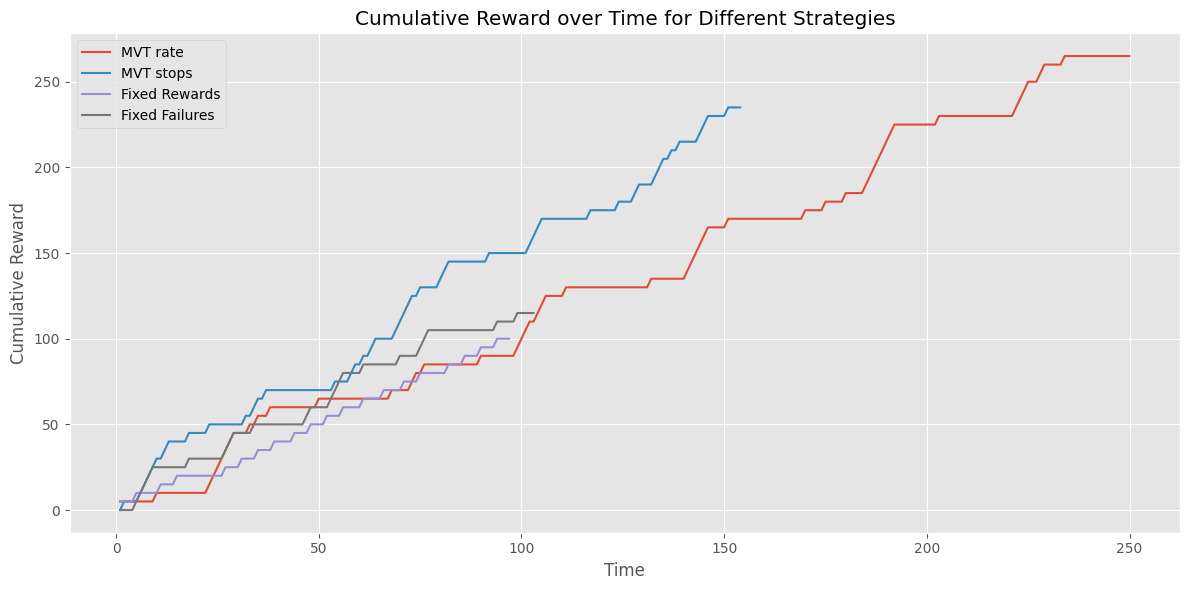

In [16]:
# Read the CSV files
# mvt_data = pd.read_csv('data/mvt_simulation_data.csv')
# fixed_rewards_data = pd.read_csv('data/fixed_rewards_simulation_data.csv')
# fixed_failures_data = pd.read_csv('data/fixed_failures_simulation_data.csv')

# Set up the plotting style
plt.style.use('ggplot')  # Using a built-in Matplotlib style

# Plot 1: Cumulative Reward over Time
plt.figure(figsize=(12, 6))
plt.plot(mvt_rate['time'], mvt_rate['reward'].cumsum(), label='MVT rate')
plt.plot(mvt_stops['time'], mvt_stops['reward'].cumsum(), label='MVT stops')
plt.plot(fixed_rewards_data['time'], fixed_rewards_data['reward'].cumsum(), label='Fixed Rewards')
plt.plot(fixed_failures_data['time'], fixed_failures_data['reward'].cumsum(), label='Fixed Failures')
plt.xlabel('Time')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time for Different Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('cumulative_reward.png')

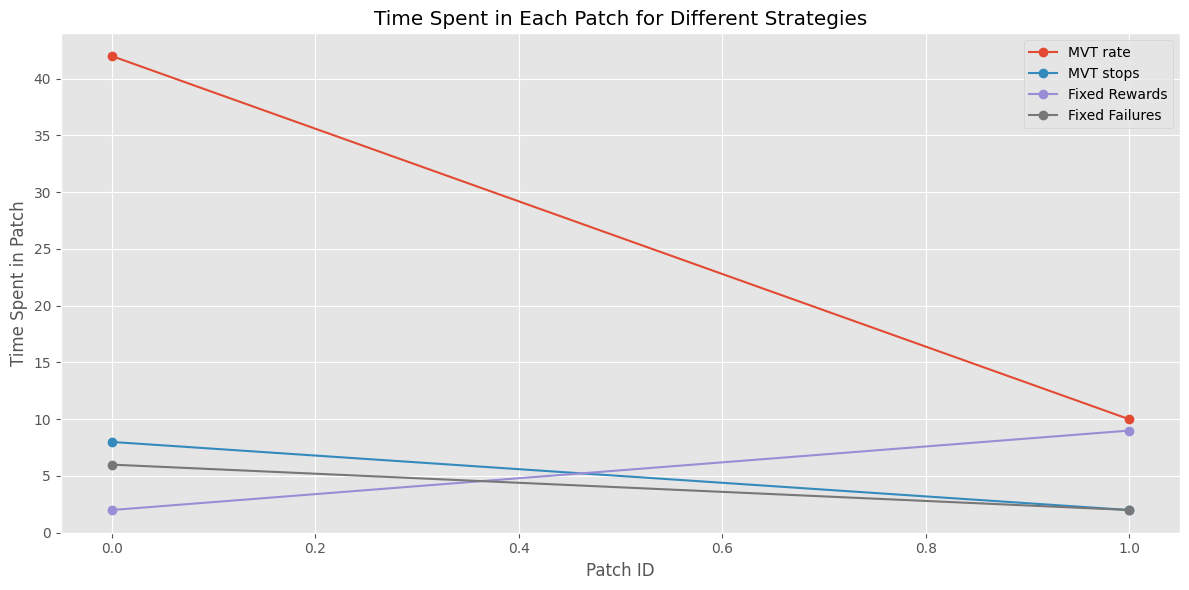

In [17]:
# Plot 2: Time Spent in Each Patch
plt.figure(figsize=(12, 6))
for data, label in zip([mvt_rate, mvt_stops, fixed_rewards_data, fixed_failures_data], 
                       ['MVT rate', 'MVT stops', 'Fixed Rewards', 'Fixed Failures']):
    patch_times = data[data['patch_id'] != -1].groupby('patch_id')['time_in_patch'].max()
    plt.plot(patch_times.index, patch_times.values, label=label, marker='o')
plt.xlabel('Patch ID')
plt.ylabel('Time Spent in Patch')
plt.title('Time Spent in Each Patch for Different Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('time_in_patch.png')

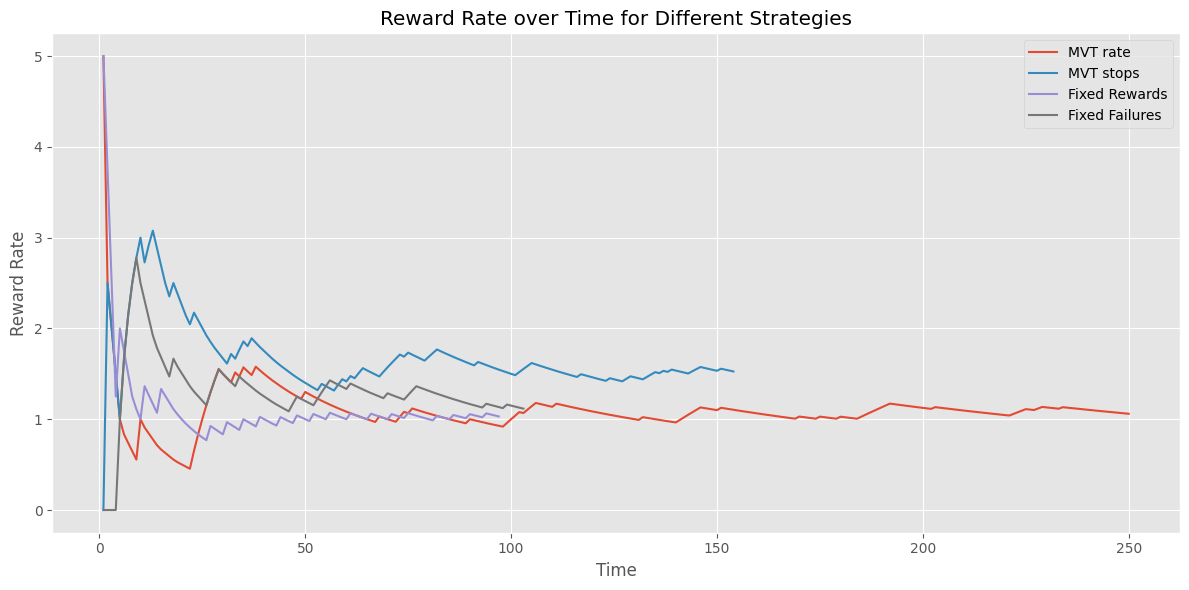

In [18]:
# Plot 3: Reward Rate over Time
plt.figure(figsize=(12, 6))
for data, label in zip([mvt_rate, mvt_stops, fixed_rewards_data, fixed_failures_data], 
                       ['MVT rate', 'MVT stops', 'Fixed Rewards', 'Fixed Failures']):
    cumulative_reward = data['reward'].cumsum()
    reward_rate = cumulative_reward / data['time']
    plt.plot(data['time'], reward_rate, label=label)
plt.xlabel('Time')
plt.ylabel('Reward Rate')
plt.title('Reward Rate over Time for Different Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('reward_rate.png')